In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, accuracy_score , recall_score , roc_auc_score, precision_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold

In [86]:
path="/Users/capucinerousset/Desktop/statapp_sujet26/"
file_name1="dataset_complet_part_1.csv"
file_name2="dataset_complet_part_2.csv"
df1 = pd.read_csv(path+file_name1, sep=',',low_memory=False)
df2 = pd.read_csv(path+file_name2, sep=',',low_memory=False)
df = pd.concat([df1,df2])

df = df.loc[df['an'] == 2019]
df['grav'] = df['grav'].replace({1:0,2:0,3:1,4:1})

#Dummy heure de pointe
def is_peak_hour(hour_minute):
    hour, minute = map(int, hour_minute.split(':'))
    total_minutes = hour * 60 + minute
    peak_hours = [(7, 0), (10, 0), (16, 30), (19, 30)]
    for start, end in zip(peak_hours[:-1], peak_hours[1:]):
        start_minutes = start[0] * 60 + start[1]
        end_minutes = end[0] * 60 + end[1]
        if start_minutes <= total_minutes < end_minutes:
            return 1
    return 0
df['HP_ind'] = df['hrmn'].apply(is_peak_hour)

#Dummy jour de semaine
df['date'] = pd.to_datetime({'year': 2019, 'month': df['mois'], 'day': df['jour']})
#df['jour_de_semaine'] = df['date'].dt.day_name()
#df = pd.get_dummies(df, columns=['jour_de_semaine'], prefix='jour', dtype=int)



#Dummy plage horaire
'''def plage_horaire(heure):
    if 5 <= heure < 12:
        return 'matin'
    elif 12 <= heure < 14:
        return 'midi'
    elif 14 <= heure < 18:
        return 'après-midi'
    elif 18 <= heure < 22:
        return 'soir'
    else:
        return 'nuit'

df['plage_horaire'] = df['hrmn'].apply(plage_horaire)
df = pd.get_dummies(df, columns=['plage_horaire'], prefix='plage_horaire', dtype=int)'''


#Dummy jour férié : 
#df['date'] = pd.to_datetime({'year': 2019, 'month': df['mois'], 'day': df['jour']})

#jours_feries_2019 = [
    #'2019-01-01', '2019-04-22', '2019-05-01', '2019-05-08', '2019-05-30', 
    #'2019-06-10', '2019-07-14', '2019-08-15', '2019-11-01', '2019-11-11', '2019-12-25'
#]

#df['jour_ferie'] = df['date'].isin(pd.to_datetime(jours_feries_2019)).astype(int)

#Vacances scolaires en 2019
vacances_2019 = [
    # Vacances d'hiver
    ('2019-02-16', '2019-03-03'),
    ('2019-02-09', '2019-02-24'),
    ('2019-02-23', '2019-03-10'),
    # Vacances de printemps
    ('2019-04-13', '2019-04-28'),
    ('2019-04-06', '2019-04-22'),
    ('2019-04-20', '2019-05-05'),
    # Vacances d'été
    ('2019-07-06', '2019-09-01'),
    # Vacances de la Toussaint
    ('2019-10-19', '2019-11-04'),
    # Vacances de Noël
    ('2019-12-21', '2019-12-31')
]

#Dummy vacances scolaires
#df['vacances_scolaires'] = 0
#for start, end in vacances_2019:
    #df.loc[(df['date'] >= start) & (df['date'] <= end), 'vacances_scolaires'] = 1

#Dummy mois
#df['mois'] = df['mois'].replace({1.:'janvier',2.:'février',3.:'mars',4.:'avril',5.:'mai',6.:'juin',7.:'juillet',8.:'août',9.:'septembre',10.:'octobre',11.:'novembre',12.:'décembre'})
#df = pd.get_dummies(df, columns=['mois'], prefix='mois', dtype=int)

# Dummy pour les variables spécifiées, en excluant les valeurs égales à -1 : celles qui ont pas de sens (valeur num )
columns_to_dummy = ['agg','int', 'catr', 'circ', 'surf', 'situ', 'infra']
 
for column in columns_to_dummy:
        df = pd.get_dummies(df, columns=[column], prefix=[column], dtype=int)

# Dummy département
def assign_region(dep_code):
    regions = {
        '1': 'Autre',
        '2': 'Hauts-de-France',
        '3': 'Autre',
        '4': 'Autre',
        '5': 'Autre',
        '6': 'Autre',
        '7': 'Autre',
        '8': 'Autre',
        '9': 'Occitanie',
        '10': 'Autre',
        '11': 'Occitanie',
        '12': 'Occitanie',
        '13': 'Autre',
        '14': 'Autre',
        '15': 'Autre',
        '16': 'Autre',
        '17': 'Autre',
        '18': 'Autre',
        '19': 'Autre',
        '2A': 'Autre',
        '2B': 'Autre',
        '21': 'Bourgogne-Franche-Comté',
        '22': 'Autre',
        '23': 'Autre',
        '24': 'Autre',
        '25': 'Bourgogne-Franche-Comté',
        '26': 'Autre',
        '27': 'Autre',
        '28': 'Autre',
        '29': 'Autre',
        '30': 'Occitanie',
        '31': 'Occitanie',
        '32': 'Occitanie',
        '33': 'Autre',
        '34': 'Occitanie',
        '35': 'Autre',
        '36': 'Autre',
        '37': 'Autre',
        '38': 'Autre',
        '39': 'Bourgogne-Franche-Comté',
        '40': 'Autre',
        '41': 'Autre',
        '42': 'Autre',
        '43': 'Autre',
        '44': 'Autre',
        '45': 'Autre',
        '46': 'Occitanie',
        '47': 'Autre',
        '48': 'Occitanie',
        '49': 'Autre',
        '50': 'Autre',
        '51': 'Autre',
        '52': 'Autre',
        '53': 'Autre',
        '54': 'Autre',
        '55': 'Autre',
        '56': 'Autre',
        '57': 'Autre',
        '58': 'Bourgogne-Franche-Comté',
        '59': 'Hauts-de-France',
        '60': 'Hauts-de-France',
        '61': 'Autre',
        '62': 'Hauts-de-France',
        '63': 'Autre',
        '64': 'Autre',
        '65': 'Occitanie',
        '66': 'Occitanie',
        '67': 'Autre',
        '68': 'Autre',
        '69': 'Autre',
        '70': 'Bourgogne-Franche-Comté',
        '71': 'Bourgogne-Franche-Comté',
        '72': 'Autre',
        '73': 'Autre',
        '74': 'Autre',
        '75': 'Île-de-France',
        '76': 'Autre',
        '77': 'Île-de-France',
        '78': 'Île-de-France',
        '79': 'Autre',
        '80': 'Hauts-de-France',
        '81': 'Occitanie',
        '82': 'Occitanie',
        '83': 'Autre',
        '84': 'Autre',
        '85': 'Autre',
        '86': 'Autre',
        '87': 'Autre',
        '88': 'Autre',
        '89': 'Bourgogne-Franche-Comté',
        '90': 'Bourgogne-Franche-Comté',
        '91': 'Île-de-France',
        '92': 'Île-de-France',
        '93': 'Île-de-France',
        '94': 'Île-de-France',
        '95': 'Île-de-France',
        '971': 'Autre',
        '972': 'Autre',
        '973': 'Autre',
        '974': 'Autre',
        '976': 'Autre',
        '977' : 'Autre', 
        '978' : 'Autre', 
        '986' : 'Autre', 
        '987' : 'Autre', 
        '988' : 'Autre',
        '2A' : 'Autre',
        '2B' : 'Autre',

    }
    return regions.get(dep_code[:2], 'Autre')

df['region'] = df['dep'].apply(assign_region)
#j'ai verif tout a été fill out avec les régions (pas de valeurs manquantes ds région)

df = pd.get_dummies(df, columns=['region'], prefix='region', dtype=int)

df = df.drop(columns=['Num_Acc','an','adr','lat','long','lartpc','larrout','com','gps','voie','dep','v2','pr','pr1','date','jour','hrmn', 'col', 'vosp', 'mois', 'lum', 'atm' , 'prof' , 'plan','infra_-1.0','infra_0.0','infra_1.0','infra_2.0','infra_3.0','infra_4.0','infra_5.0','infra_6.0','infra_8.0','infra_9.0', 'situ_5.0','situ_-1.0','situ_2.0','situ_3.0','situ_6.0','situ_8.0','surf_9.0','surf_8.0','surf_7.0','surf_6.0','surf_3.0','surf_2.0','surf_1.0','surf_-1.0','circ_4.0','circ_3.0','circ_1.0','circ_-1.0','catr_9.0','catr_7.0','catr_6.0','catr_5.0','catr_4.0','catr_2.0','int_9.0','int_7.0','int_6.0','int_5.0','int_4.0','int_3.0','int_2.0','int_1.0','region_Autre'])
#ici on enlève an car on ne regarde que pour 2019
#df['hrmn'] = df['hrmn'].str.split(':').str[0]

df.to_csv('lin2.csv', index=False)

y = df['grav']
X = df.drop(columns=['grav'])
features = X.columns

#'lum'  'int'  'atm' , 'prof' , 'plan'

In [87]:
# Diviser le jeu de données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#Inférer les valeurs non renseignées
imputer = SimpleImputer(strategy='mean')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)

#Ajuster Y pour fitter avec la nouvelle base de features
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

#Trouver le alpha optimal
LassoRegression = Lasso(max_iter=2000)
hyperParameters = {'alpha':np.logspace(-6, -4, 100)}
LassoRegressor = GridSearchCV(LassoRegression, hyperParameters, scoring='neg_mean_squared_error', cv=5)
LassoRegressor.fit(X_train_imp,y_train)

print("Best value for lambda : ",LassoRegressor.best_params_)
print("Best score for cost function: ", LassoRegressor.best_score_)



Best value for lambda :  {'alpha': 3.5938136638046256e-05}
Best score for cost function:  -0.1815523222769159


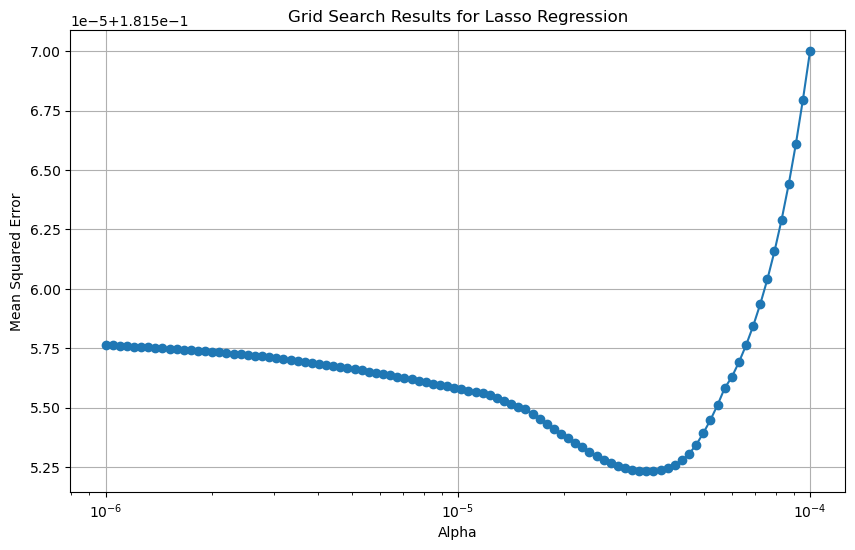

In [88]:
results = LassoRegressor.cv_results_
alphas = results['param_alpha']
scores = -results['mean_test_score']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(alphas, scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Grid Search Results for Lasso Regression')
plt.grid(True)
plt.show()

In [89]:
#Créer le modèle linéaire et l'entrainer sur les bases test
model = Lasso(alpha=3.59e-05)
model.fit(X_train_imp, y_train)

#Tester le modèle sur la base de features test
y_pred = model.predict(X_test_imp)

for i in range(len(y_pred)):
    if y_pred[i]>(1/2):
        y_pred[i]=int(1)
    else: y_pred[i]=int(0)

In [90]:
f1 = f1_score(y_test, y_pred)
print("F1:", f1)

F1: 0.5782802954317497


10 most important coefficients:
region_Île-de-France: -0.21800815642167418
agg_1.0: 0.18995424484723425
int_8.0: 0.17150346017218596
situ_1.0: -0.13957787236473349
catr_3.0: 0.12962101889526306
catr_1.0: -0.1129521940879406
region_Bourgogne-Franche-Comté: 0.09881999724088142
infra_7.0: 0.09094697853469437
surf_5.0: -0.08778542288927413
region_Hauts-de-France: 0.08600056056671591
['region_Île-de-France', 'agg_1.0', 'int_8.0', 'situ_1.0', 'catr_3.0', 'catr_1.0', 'region_Bourgogne-Franche-Comté', 'infra_7.0', 'surf_5.0', 'region_Hauts-de-France'] [0.21800815642167418, 0.18995424484723425, 0.17150346017218596, 0.13957787236473349, 0.12962101889526306, 0.1129521940879406, 0.09881999724088142, 0.09094697853469437, 0.08778542288927413, 0.08600056056671591]


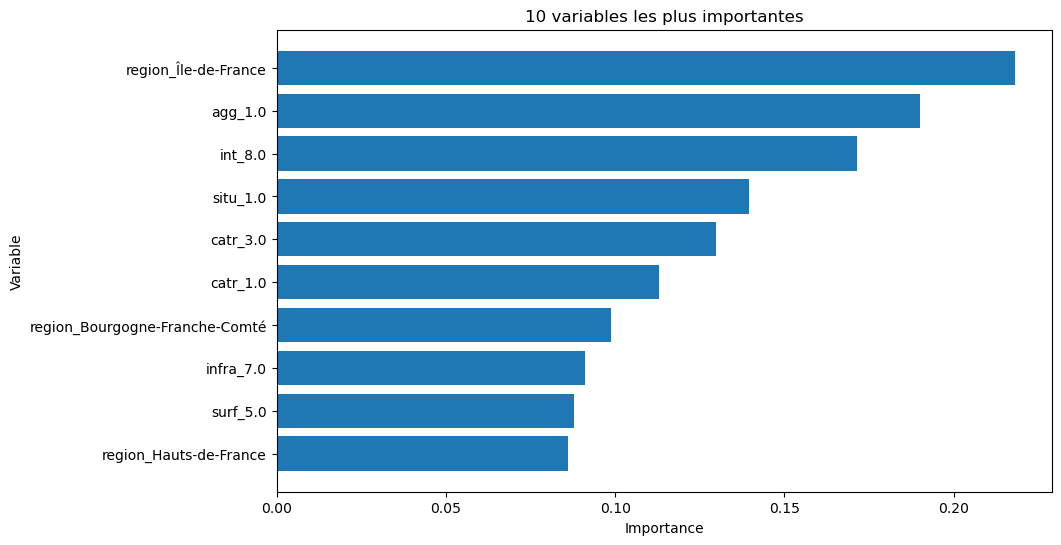

In [95]:
# On récupère les coefficients
coefficients = model.coef_

# Les associer à leur feature 
feature_importance = list(zip(features, coefficients))


# Trier les coefficients par valeur absolue
feature_importance_sorted = sorted(feature_importance, key=lambda x: abs(x[1]), reverse=True)

# Afficher les 10 coefficients les plus importants
variables=[]
coeffs=[]
print("10 most important coefficients:")
for i in range(10):
    feature, importance = feature_importance_sorted[i]
    print(f"{feature}: {importance}")
    variables.append(feature)
    coeffs.append(abs(importance))
print(variables, coeffs)


# Tracer l'importance des 10 variables les plus importantes
# Tracer l'importance des 15 variables les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(variables, coeffs)
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('10 variables les plus importantes')
plt.gca().invert_yaxis()  # Inverser l'axe y pour avoir la variable la plus importante en haut


plt.show()

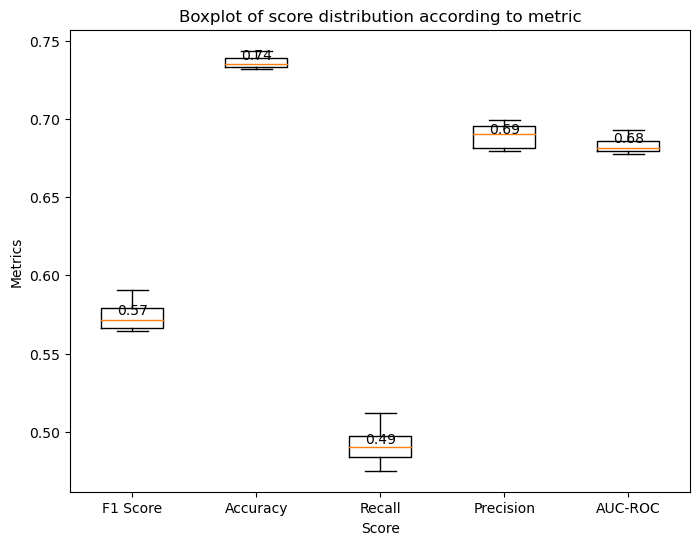

In [94]:
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

lr_model = Lasso(alpha=3.59e-05)

f1s= []
accuracies =[]
recalls=[]
precisions=[]
auc_rocs=[]



# Iterate through each fold
for train_index, test_index in skf.split(X, y):
    X_train2, X_test2 = X.iloc[train_index], X.iloc[test_index]
    y_train2, y_test2 = y.iloc[train_index], y.iloc[test_index]

    imputer = SimpleImputer(strategy='mean')
    X_train_imp2 = imputer.fit_transform(X_train2)
    X_test_imp2 = imputer.transform(X_test2)
    
    # Fit the model
    lr_model.fit(X_train_imp2, y_train2)
    
    # Predict on the test set
    y_pred2 = lr_model.predict(X_test_imp2)

    for i in range(len(y_pred2)):
        if y_pred2[i]>(1/2):
            y_pred2[i]=int(1)
        else: y_pred2[i]=int(0)

    accuracy = accuracy_score(y_test2, y_pred2)
    recall = recall_score(y_test2, y_pred2)
    precision = precision_score(y_test2, y_pred2)
    auc_roc = roc_auc_score(y_test2, y_pred2)

    f1s.append(f1_score(y_pred2,y_test2))
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
    auc_rocs.append(auc_roc)

plt.figure(figsize=(8, 6))
plt.boxplot([f1s, accuracies, recalls, precisions, auc_rocs],
            labels=['F1 Score', 'Accuracy', 'Recall', 'Precision', 'AUC-ROC'])
# Calculate mean values for each box plot
mean_values = [np.mean(d) for d in [f1s, accuracies, recalls, precisions, auc_rocs]]

# Add mean values to the plot
for i, mean in enumerate(mean_values, start=1):
    plt.text(i, mean, f'{mean:.2f}', ha='center', va='bottom', color='black')
plt.xlabel('Score')
plt.ylabel('Metrics')
plt.title('Boxplot of score distribution according to metric')
plt.show()